In [1]:
import pyreadr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timeit

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import graphviz
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [12]:
result = pyreadr.read_r('..\Topsail_hab.rds')
df = result[None]
df['Wetland'] = np.where(df['Habitat']==(1.0 or 2.0), 0, 1)
df

,Habitat,DEM,sDEM,hDEM,DSM,CHM,Aspect,Slope,Curvature,PlanCurv,ProfileCurv,NDVI,NDRE,NDWI,x,y,Wetland
0,1.0,15.240647,15.146869,15.420612,18.154158,2.913510,117.422546,8.176274,-25.975969,-52.978203,-27.002234,0.594243,0.520426,-0.533454,730804.385965,72984.511287,0
1,1.0,14.887038,15.095878,15.420612,17.203264,2.316226,208.086426,6.672442,316.628357,124.757317,-191.871033,0.691504,0.500978,-0.645083,730767.794514,72980.611873,0
2,1.0,16.359131,16.163313,16.372206,16.359131,0.000000,161.332886,6.790757,-124.263763,-55.304470,68.959290,0.644416,0.512921,-0.546609,730648.722331,72975.212684,0
3,3.0,14.284998,14.211570,15.420612,16.938608,2.653610,345.371765,17.630831,-255.444839,-246.092529,9.352321,0.757325,0.698286,-0.679980,730768.694303,72914.621786,1
4,1.0,14.499788,14.791419,15.420612,16.624233,2.124445,64.686241,0.072736,-66.608856,-52.114315,14.494536,0.398862,0.395540,-0.464029,730752.798017,72907.122912,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,6.0,16.693388,16.989958,16.962177,16.693388,0.000000,149.288040,8.963833,-108.939278,-36.148613,72.790665,0.724189,0.453004,-0.633350,730331.696393,72277.817450,1
86,6.0,17.068039,17.007517,17.211912,19.701313,2.633274,34.361065,44.094032,12.969971,141.186569,128.216599,0.863583,0.660652,-0.700924,730287.306763,72275.117856,1
87,3.0,16.091032,15.534839,16.789028,16.457705,0.366673,46.493004,20.720913,450.084473,270.845642,-179.238815,0.694675,0.552781,-0.670484,730226.121057,72263.119658,1
88,6.0,16.866083,16.970697,17.035009,18.924875,2.058792,59.140148,16.518654,-917.390198,-556.275635,361.114532,0.785422,0.552671,-0.674733,730324.798004,72261.919839,1


In [13]:
# Models takes in X for co-variates, y for outcome. gridid is a series with all the gridids
def LGB(X, y, gridid):
    # acc_score holds accuracy of all cross-validation iterations. Used to compute mean accuracy
    acc_score = [];
    # contains all truth values for each grid
    Truth = [];
    # contains all output values for each grid
    Output = [];
    # dataframe of grid ids(same as gridid that's passed in)
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])
    # 5 fold Cross-validation
    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    
    # tqdm tracks how many iterations are done(useful for calculating how long processing will take) but not used for anything else
    # train_index and test_index are the indexes of the splits within the cross validation
    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        # X_train and X_test are the values within the dataframe for the train and test indexes
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        # similar to X_train and y_train
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        # Get the grid id of the grid at the train index
        train_grid = gridid.iloc[train_index]
        # get the grid id of the grid at the test index 
        test_grid= gridid.iloc[test_index]
        
        # Assign a model
        model = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)
 
        # Fit the model to the train and predict the test
        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        
        # Calculate the accuracy based on the predicted values
        acc = accuracy_score(y_test, pred_values)
        #Add the accuracy to the accuracy score array so we can take the average later
        acc_score.append(acc)
        
        # add the new grid(test_grid) to the data frame of gir ids
        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        # add the truth values we calculated to the truth array with data from all cross validations
        #i'm not sure about the exact reason why we reshape the array though :/
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        ## add the output values, same way as above
        Output.extend(pred_values);
    
    ## calculate mean accuracy
    accuracy = np.mean(acc_score)
    ## Combine grid id, truth, and output so it can be returned
    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    ## Calculate confusion matrix
    conf_mat = confusion_matrix(Truth, Output)
    ## Classification report
    class_rep = classification_report(Truth, Output, digits=4)
    ## Return outputs
    return output_df, accuracy, conf_mat, class_rep

In [14]:
def LGBM(X, y, coords):
    fig, ax = plt.subplots()
    tree_axs = []
    
    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    Coordinates = pd.DataFrame(columns=['x', 'y'])

    feature_importances = pd.DataFrame()
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_coord = coords.iloc[train_index]
        test_coord = coords.iloc[test_index]

        model = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        
        t_ax = lgb.plot_tree(model, orientation='horizontal')
        tree_axs.append(t_ax)
        
        feature_importance = model.feature_importances_
        rel_imp = pd.DataFrame(feature_importance, index=X_train.columns, columns=[i])
        feature_importances = pd.concat([feature_importances, rel_imp], axis=1)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Coordinates = pd.merge(Coordinates, test_coord, on=['x', 'y'], how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for Light Gradient Boosting Model")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    
    feature_importances['mean'] = feature_importances.iloc[:, 0:5].mean(axis=1)
    
    output_df = pd.concat([Coordinates, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt, feature_importances['mean'], tree_axs

5it [00:00,  6.13it/s]


0.8186852000000044 seconds
[0.7222222222222222, 0.7777777777777778, 0.6666666666666666, 0.6111111111111112, 0.6666666666666666]
0.6888888888888889 accuracy
[[ 8 18]
 [10 54]]
              precision    recall  f1-score   support

           0     0.4444    0.3077    0.3636        26
           1     0.7500    0.8438    0.7941        64

    accuracy                         0.6889        90
   macro avg     0.5972    0.5757    0.5789        90
weighted avg     0.6617    0.6889    0.6698        90

<module 'matplotlib.pyplot' from 'C:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


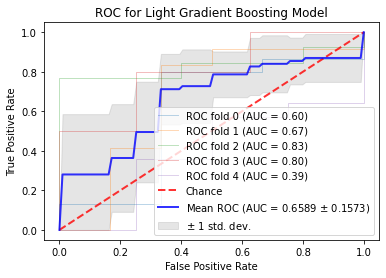

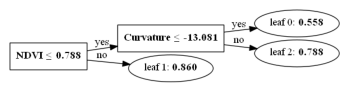

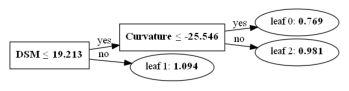

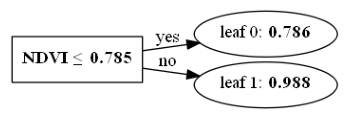

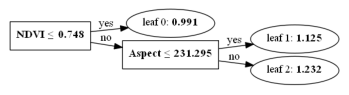

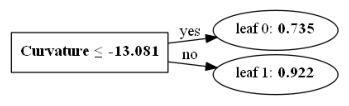

In [15]:
X = df.drop(['x', 'y', 'Habitat', 'Wetland'], axis=1)
y = df.Wetland
coords = df[['x', 'y']]
output_df, time, cm, cr, acc, roc, feat_imp, tree_axs = LGBM(X, y, coords)
print(f"{time} seconds")
print(f"{acc}")
print(f"{np.mean(acc)} accuracy")
print(cm)
print(cr)
print(roc)

Text(0.5, 1.0, 'Variable Importance')

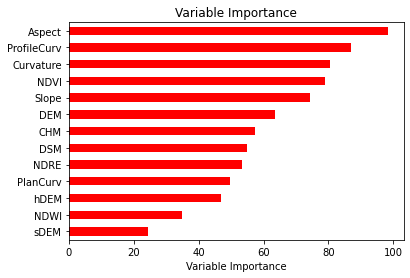

In [16]:
fig = feat_imp.sort_values()[-24:].T.plot(kind = 'barh', 
               color = 'r')
fig.set_xlabel("Variable Importance")
fig.set_title("Variable Importance")

In [17]:
result = pyreadr.read_r('..\Topsail_all.rds')
df_all = result[None]

In [18]:
X_all = df_all.drop(['x', 'y', 'Habitat'], axis=1)
coords_all = df_all[['x', 'y']]

Coords = coords_all
Output = []

In [19]:
model = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)
model.fit(X, y)
pred_values = model.predict(X_all)
Output.extend(pred_values)

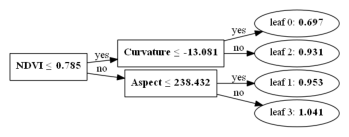

In [20]:
t_ax = lgb.plot_tree(model, orientation='horizontal')

In [21]:
test_df = pd.concat([Coords, pd.DataFrame(Output, columns=["Output"])], axis=1)

In [22]:
test_df.to_csv("../Comparison Data/TopsailLGB.csv", index=False)

In [23]:
test_df['Output'].value_counts()

1    4143932
0     950488
Name: Output, dtype: int64